In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rotation_range=30, rescale=1./255, validation_split=0.2)

In [28]:
image_size = (235, 235)
train_gen = data_gen.flow_from_directory('train', target_size=image_size, shuffle=True, seed=42) # class_mode default categorical
test_gen = data_gen.flow_from_directory('test', target_size=image_size, shuffle=True, seed=42) # default batch_size is 32

Found 14140 images belonging to 101 classes.
Found 6060 images belonging to 101 classes.


In [29]:
test_gen.labels


array([  0,   0,   0, ..., 100, 100, 100], dtype=int32)

In [30]:
from tensorflow.keras.applications import InceptionV3

input_shape = (235, 235, 3) # 235, 235 stands for w and h. The 3 stands for the three channels for RGB
inception_model = InceptionV3(weights="imagenet", input_shape=input_shape, include_top=False)

inception_model.trainable = False # freeze weights

In [31]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

model = Sequential()
model.add(inception_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(128, activation="relu")) # 64 units
model.add(Dense(128, activation="relu")) # added another layer
model.add(Dense(128, activation="relu")) # added a third layer
model.add(Dense(128, activation="relu")) # added a fourth layer
model.add(Dropout(0.2))
model.add(Dense(101, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                      

In [32]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='food_model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

In [34]:
history = model.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30


2023-04-11 20:47:32.054952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - ETA: 0s - loss: 3.7780 - accuracy: 0.1286

2023-04-11 20:49:17.393769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3.06774, saving model to food_model.hdf5
442/442 [==============================] - 153s 341ms/step - loss: 3.7780 - accuracy: 0.1286 - val_loss: 3.0677 - val_accuracy: 0.2353
Epoch 2/30
442/442 [==============================] - ETA: 0s - loss: 3.0029 - accuracy: 0.2535
Epoch 2: val_loss improved from 3.06774 to 2.77040, saving model to food_model.hdf5
442/442 [==============================] - 150s 339ms/step - loss: 3.0029 - accuracy: 0.2535 - val_loss: 2.7704 - val_accuracy: 0.2988
Epoch 3/30
442/442 [==============================] - ETA: 0s - loss: 2.7309 - accuracy: 0.3125
Epoch 3: val_loss improved from 2.77040 to 2.64810, saving model to food_model.hdf5
442/442 [==============================] - 152s 344ms/step - loss: 2.7309 - accuracy: 0.3125 - val_loss: 2.6481 - val_accuracy: 0.3314
Epoch 4/30
442/442 [==============================] - ETA: 0s - loss: 2.5596 - accuracy: 0.3471
Epoch 4: val_loss improved from 2.64810 to 2.54843, saving

In [40]:
model.load_weights('food_model.hdf5')

In [41]:
import numpy as np

output = np.argmax(model.predict(test_gen), axis=1)

190/190 [==============================] - 45s 236ms/step


In [42]:
print(output)
print(np.mean(output == test_gen.labels))

[44  6 90 ... 50 72 13]
0.011386138613861386


<AxesSubplot:>

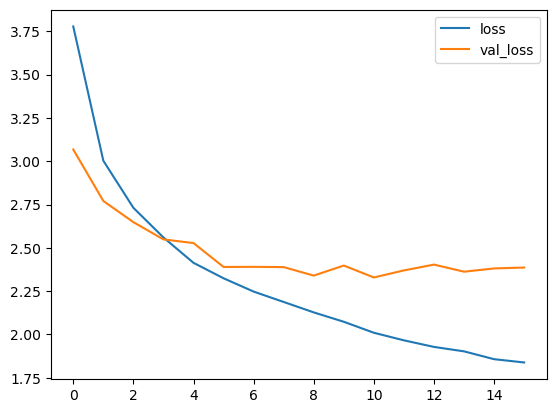

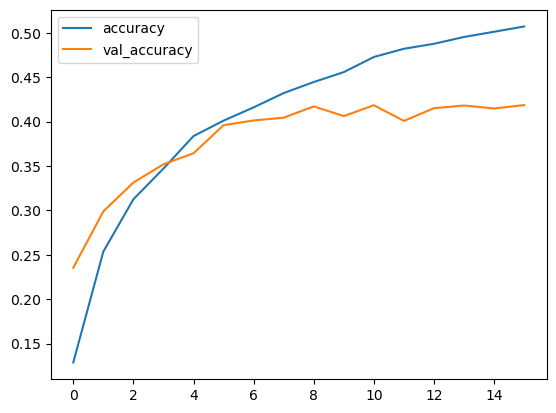

In [43]:
import pandas as pd
from tensorflow import keras

history_df = pd.DataFrame(history.history)
#history_df = keras.models.load_model("food_model.hdf5")
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

In [44]:
print(max(history_df['val_accuracy']))

0.4186468720436096
